# Курсовой проект Алгоритмы анализа данных регрессия

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import numpy as np

In [18]:
def r2_(x, y):
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2_(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    plt.scatter(pred_values, true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
data_csv=pd.read_csv('train.csv')

In [4]:
X=data_csv.drop(["mean_exam_points",'Id'], axis=1)
y=data_csv['mean_exam_points']

In [5]:
X=X.values
y=y.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.25)

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction

In [9]:
class Tree:
    
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

      # Расчёт дисперсии значений
    def var_R(self, labels):
        return np.std(labels)



    def quality(self, left_labels, right_labels, current_dispersion):

        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_dispersion - p * np.std(left_labels) - (1 - p) * np.std(right_labels)
       

    # Разбиение датасета в узле

    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):
    
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_dispersion = self.var_R(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_dispersion)

            #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels, tree_depth, max_depth):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
        if tree_depth >= max_depth:
            return Leaf(data, labels)

        # Увеличиваем глубину дерева на 1
        tree_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, tree_depth, max_depth)
        false_branch = self.build_tree(false_data, false_labels, tree_depth, max_depth)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def predict_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)

    def predict(self, data):
    
        predictions = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            predictions.append(prediction)
        return predictions

    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, 0, self.max_depth)
        return self

In [10]:
class Gradient_Boosting:
    
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []

    def bias(self, y, z):
        return (y - z)

    def fit(self, X_train, y_train):
       # Деревья будем записывать в список
        for i in range(self.n_trees):
            tree = Tree(max_depth=self.max_depth)
           # train_ind = np.random.randint(X_train.shape[0],size=int(X_train.shape[0]/2))
           # X_train_=X_train[train_ind]
           # y_train_=y_train[train_ind]

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                bias = self.bias(y_train, target)
                tree.fit(X_train, bias)

            self.trees.append(tree)

        return self

    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [11]:
# Число деревьев в ансамбле
n_trees = 30

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5
# Шаг
eta = 0.5

In [12]:
gb_model = Gradient_Boosting(n_trees, max_depth, coefs, eta)
gb_model.fit(X_train, y_train)
train_answers = gb_model.predict(X_train)
test_answers = gb_model.predict(X_test) 

R2:	0.792


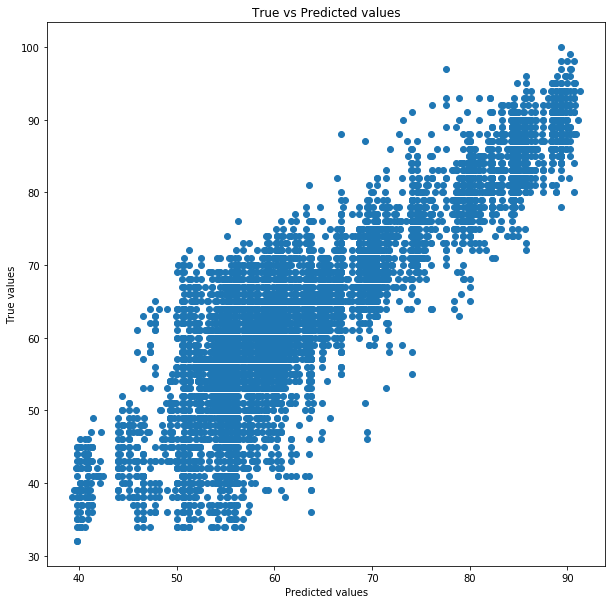

In [20]:
evaluate_preds(y_train,train_answers)

R2:	0.78


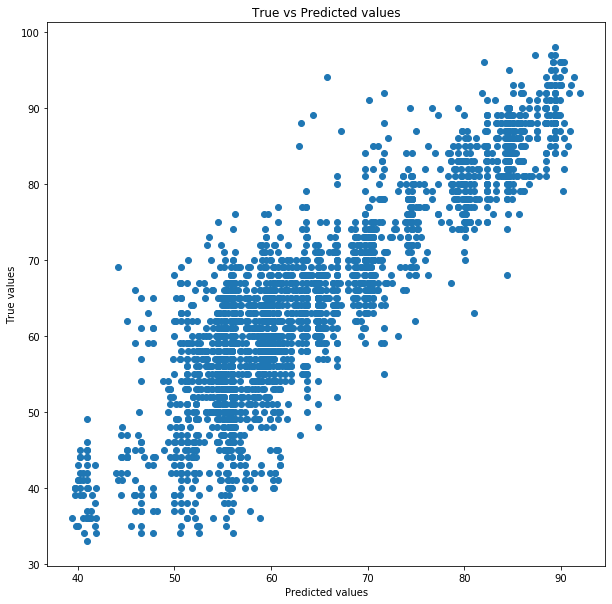

In [21]:
evaluate_preds(y_test,test_answers)

In [22]:
data_test=pd.read_csv('test.csv')

In [23]:
X_tst=data_test.drop(['Id'], axis=1)

In [24]:
X_tst=X_tst.values

In [25]:
test_ = gb_model.predict(X_tst) 

In [26]:
data_it=data_test.copy()

In [27]:
data_it['mean_exam_points']=np.round(test_,1)

In [28]:
data_it[['Id','mean_exam_points']].to_csv('test_answer.csv',index=False)